In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
# from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
from osgeo.gdal import BuildVRT, SetConfigOption
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
from shapely.geometry import Point
from geopandas import gpd 

version = 'v20250521'


## discretization points

In [2]:
sizes = ['50','100','200'] #

pnt = []
for isize in sizes:
    ttprint(f'read {isize}')
    ip = gpd.read_file(f'./material/pnt_all.{isize}km_agg.gpkg')
    ip['size'] = f'{isize}km'
    
    # poly = gpd.read_file(f'./material/grid_all.{isize}km_agg.gpkg')

    pnt.append(ip)
    print(ip.shape)

[08:14:11] read 50
(863365, 17)
[08:16:59] read 100
(220170, 24)
[08:18:07] read 200
(53954, 19)


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [72]:
ip50 = pnt[0][['id','CNTR_CODE', 'geometry', 'size']]
ip100 = pnt[1][['id','CNTR_CODE', 'geometry', 'size']]
ip200 = pnt[2][['id','CNTR_CODE', 'geometry', 'size']]

ip50['50km'] = 1
ip50['100km'] = 0
ip50['200km'] = 0
ip50.loc[ip50['geometry'].isin(ip100['geometry']), '100km'] = 1
ip50.loc[ip50['geometry'].isin(ip200['geometry']), '200km'] = 1

ip50 = ip50.rename(columns={'CNTR_CODE':'nuts0'})

# ip50['100km'].sum()/len(ip50)
# ip50['200km'].sum()/ip50['100km'].sum()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [73]:
# read in polygons
polygon = []
for isize in sizes:
    poly = gpd.read_file(f'./material/grid_all.{isize}km_agg.gpkg')
    poly[f'id_{isize}km'] = poly.index
    polygon.append(poly)
    
    #join with grids
    ip50 = gpd.sjoin(ip50, poly[[f'id_{isize}km', 'geometry']], how='left', predicate='within')
    ip50 = ip50.drop(columns=['index_right'])
    
    # only keep grids with enough discretinization points
    group_counts = ip50.loc[ip50[f'{isize}km']==1].groupby(f'id_{isize}km').size().reset_index(name='count')
    keep_ids = group_counts.loc[group_counts['count']>2000,f'id_{isize}km'].tolist()
    poly = poly.loc[poly[f'id_{isize}km'].isin(keep_ids), ['CNTR_CODE','geometry', f'id_{isize}km']]
    poly.to_file(f'./material/grid_all.{isize}km_agg.{version}.gpkg')
    
    # mark points outsize valid grids
    ip50.loc[~ip50[f'id_{isize}km'].isin(keep_ids), f'{isize}km'] = 0

In [80]:
ipf = ip50.loc[(ip50['50km']==1)|(ip50['100km']==1)|(ip50['200km']==1)]

In [82]:
from shapely.geometry import Point, MultiPoint

def convert_multipoint_to_point(geom):
    if isinstance(geom, MultiPoint) and len(geom.geoms) == 1:
        return geom.geoms[0]  # extract the single Point
    return geom  # leave unchanged if already Point or other

ipf['geometry'] = ipf['geometry'].apply(convert_multipoint_to_point)
ipf = ipf.drop(columns=['size'])
ipf['id'] = ipf.index

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [84]:
print(len(ipf)/len(ip50))
ipf

0.862081506662883


,id,nuts0,geometry,50km,100km,200km,id_50km,id_100km,id_200km
322,322,DE,POINT (4046952.408 3192085.582),1,0,0,280.0,93.0,32.0
323,323,DE,POINT (4046952.408 3191085.582),1,0,0,280.0,93.0,32.0
324,324,DE,POINT (4046952.408 3190085.582),1,0,0,280.0,93.0,32.0
325,325,DE,POINT (4046952.408 3189085.582),1,0,0,280.0,93.0,32.0
326,326,DE,POINT (4046952.408 3188085.582),1,0,0,280.0,93.0,32.0
...,...,...,...,...,...,...,...,...,...
861776,861776,ES,POINT (3745821.224 1856326.139),1,0,0,264.0,83.0,27.0
861777,861777,ES,POINT (3745821.224 1855326.139),1,0,0,264.0,83.0,27.0
861778,861778,ES,POINT (3745821.224 1854326.139),1,0,0,264.0,83.0,27.0
861779,861779,ES,POINT (3745821.224 1853326.139),1,0,0,264.0,83.0,27.0


In [85]:
ipf.to_file(f'./material/pnt_agg_all.{version}.gpkg')

<Axes: >

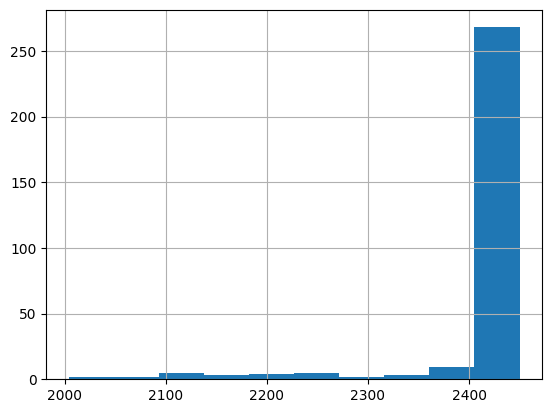

In [91]:
isize = 50

ipt = ip50.loc[ip50[f'{isize}km']==1]
# print(ipt[f'{isize}km'].sum()/len(ip50[f'id_{isize}km'].unique()))
group_counts = ipt.groupby(f'id_{isize}km').size().reset_index(name='count')
group_counts['count'].hist()



## observations

In [8]:
df = pd.read_parquet(f'./material/srs_lucas.plausible_{version}.pq')
df = df[['id', 'ref', 'nuts0', 'lat_mean', 'lon_mean', 'time_series', 'soc_series','lc']]
print(df.shape)

# df['time_str'] = df['time_pair'].str[0].astype(str) + '-' + df['time_pair'].str[1].astype(str) 
# df = df.loc[df['time_str'] == '2009-2018']
# print(df.shape)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_mean, df.lat_mean))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs('EPSG:3035')

(10204, 8)


In [10]:
sizes = ['50','100','200']
# join grid with paired points
for isize in sizes:
    poly = gpd.read_file(f'./material/grid_all.{isize}km_agg.{version}.gpkg')
    
    gdf = gpd.sjoin(gdf, poly, how='left', predicate='within')
    gdf = gdf.drop(columns=['index_right','CNTR_CODE'])
    
#     # only keep grids with enough discretinization points
#     group_counts = ip50.loc[ip50[f'{isize}km']==1].groupby(f'id_{isize}km').size().reset_index(name='count')
#     keep_ids = group_counts.loc[group_counts['count']>2000,f'id_{isize}km'].tolist()
#     poly = poly.loc[poly[f'id_{isize}km'].isin(keep_ids), ['CNTR_CODE','geometry', f'id_{isize}km']]
#     poly.to_file(f'./material/grid_all.{isize}km_agg.{version}.gpkg')
    
#     # mark points outsize valid grids
#     ip50.loc[~ip50[f'id_{isize}km'].isin(keep_ids), f'{isize}km'] = 0

fdf = gdf.loc[(gdf['id_50km'].notna())|(gdf['id_100km'].notna())|(gdf['id_200km'].notna())]


In [15]:
fdf.to_parquet(f'./material/srs_agg_{version}.pq')